In [0]:
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/lab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

# Auther: Seongwoo Kim
#한 이미지 내의 숫자가 몇개 있는지 세는 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
import torch.utils.model_zoo as model_zoo



USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS     = 60
BATCH_SIZE = 60

img_size = 224              #인풋으로 받는 이미지의 크기
class_num = 20

transform = transforms.Compose([
    transforms.ToTensor()
])
custom_transform = transforms.Compose([
    #transforms.RandomRotation(15),
    transforms.Normalize((0.1307,),(0.3881,)),
    
])

trainset = datasets.MNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform,
)


train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)


def find_contour(img):
  Img = (img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  W, H = 28, 28
  Img_size = W * H
  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  group = list()
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.0008 and area < Img_size * 0.8 and hierachy[0,n,3] == -1):
          group.append((area, n))
  group.sort()
  if(len(group)== 0):
    print('error')
    return torch.zeros(1,28,28)
  x, y, w, h = cv2.boundingRect(contours[group[-1][1]])
  return img[:,y:y+h,x:x+w]


class CustomDataset(Dataset):                                                   #1~4개의 숫자 그림을 MNIST에서 받아서 한 이미지 내에 넣은 데이터셋 생성 
    def __init__(self, loader, transform=None):
        data_total = len(loader)*BATCH_SIZE                                     #60000
        self.transform = transform
        self.x_data = torch.zeros(data_total*4//10,1,img_size,img_size*3//2).to(DEVICE)
        self.y_data = torch.zeros(data_total*4//10,class_num).to(DEVICE)
        for batch_idx, (data, target) in enumerate(loader):                     #data는 [50,1,28,28]
            print(batch_idx)
            data, target = data.to(DEVICE), target.to(DEVICE)
            if(batch_idx * BATCH_SIZE < data_total//10):                        #숫자가 1개 있는 샘플
                points_num = 1  
            elif(batch_idx * BATCH_SIZE < data_total*3//10): 
                points_num = 2                               #숫자가 2개 있는 샘플
            elif(batch_idx * BATCH_SIZE < data_total*6//10):
                points_num = 3                               #숫자가 3개 있는 샘플
            else:
                points_num = 4                               #숫자가 4개 있는 샘플
            for count in range(BATCH_SIZE):
                if(count%points_num == 0):                       
                    x_position = 0
                    image_list = list()               
                    padding_sum = random.randrange(0,70)
                up_padding = random.randrange(0,padding_sum+1)
                down_padding = padding_sum - up_padding
                image_cut = find_contour(data[count,:,:,:]).to(DEVICE)
                _, Y, X = image_cut.shape
                image_cut = F.interpolate(image_cut.unsqueeze(0), size=(img_size, round(img_size * X / Y)), mode='area')
                image_cut = torch.cat((torch.zeros(1,1,up_padding,round(img_size * X / Y)).to(DEVICE), image_cut), dim=2)
                image_cut = torch.cat((image_cut, torch.zeros(1,1,down_padding,round(img_size * X / Y)).to(DEVICE)), dim=2)
                image_list.append((x_position,round(img_size * X / Y), image_cut))
                x_position += round(img_size * X / Y)
                if((count+1)%points_num == 0):
                    ratio = random.random()*0.2 + 0.8
                    if(points_num > 1):
                      x_length = max(img_size+padding_sum,round(image_list[-1][0]*ratio)+image_list[-1][1],img_size+padding_sum,round(image_list[-2][0]*ratio)+image_list[-2][1])
                    else:
                      x_length = image_list[-1][1]
                    tmp_tensor = 	torch.zeros(1,1,img_size+padding_sum,x_length).to(DEVICE)
                    for idx in range(points_num):
                      tmp_tensor[:,:,:,round(image_list[idx][0]*ratio):round(image_list[idx][0]*ratio)+image_list[idx][1]].add_(image_list[idx][2])      
                    tmp_tensor = torch.clamp(F.interpolate(tmp_tensor,size=(img_size, img_size*3//2), mode='area'),0,1)
                    self.x_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num,:,:,:].add_(tmp_tensor.squeeze())
                    for n in range(points_num):
                        hotkey = round((image_list[n][0]*ratio+image_list[n][1]/2)/(x_length)*(class_num-1))
                        self.y_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num, hotkey].add_(1)
                        if(0 < hotkey and hotkey < class_num - 1):
                            self.y_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num, hotkey+1].add_(0.3)
                            self.y_data[data_total//20 * (points_num - 1) + (batch_idx * BATCH_SIZE + count) // points_num, hotkey-1].add_(0.3)

    def __len__(self):
        return self.x_data.shape[0]
    def __getitem__(self, idx):
        x = self.x_data[idx,:,:,:]
        if self.transform:
            x = self.transform(x)
        return x, self.y_data[idx,:]

custom_dataset = CustomDataset(train_loader, transform = custom_transform)
custom_trainset, custom_testset = torch.utils.data.random_split(custom_dataset, [20000, 4000])

custom_train_loader = torch.utils.data.DataLoader(
    dataset     = custom_trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
)

custom_test_loader = torch.utils.data.DataLoader(
    dataset     = custom_testset,
    batch_size  = BATCH_SIZE,
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            #nn.Sigmoid(),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # 16 +3 =vgg 19
}
conv = make_layers(cfg['B'], batch_norm=True)


model = VGG(make_layers(cfg['B']), num_classes=class_num, init_weights=True).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 1e-4)
criterion = nn.BCEWithLogitsLoss()


#MNIST 데이터셋을 이용해 학습 진행
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


# ## 테스트하기
def process(output, target):
  points_num = torch.ones_like(target).eq(target).sum(dim=1)
  res = torch.zeros_like(output)
  batch_size, length = target.shape
  for n in range(batch_size):
    peak_list = list()
    focus = output[n,:]
    for k in range(points_num[n].item()):
      targetidx = focus.max(dim=0)[1].item()
      peak_list.append(targetidx)
      for j in range(-1, 2):
        if(0 <= targetidx+j  and targetidx+j < length):
          focus[targetidx+j].sub_(2)
    for ele in peak_list:
      res[n,ele].add_(1) 
  return res

def process(output, target):
  correct = 0
  points_num = torch.ones_like(target).eq(target).sum(dim=1)
  batch_size, length = target.shape
  for n in range(batch_size):
    same = True
    peak_list = list()
    focus = output[n,:]
    for k in range(points_num[n].item()):
      targetidx = focus.max(dim=0)[1].item()
      peak_list.append(targetidx)
      for j in range(-1, 2):
        if(0 <= targetidx+j  and targetidx+j < length):
          focus[targetidx+j].sub_(2)
    for ele in peak_list:
      if(target[n,ele] != 1):
        same = False
    if(same): correct += 1
  return correct

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target).sum().item()
            correct += process(output,target)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


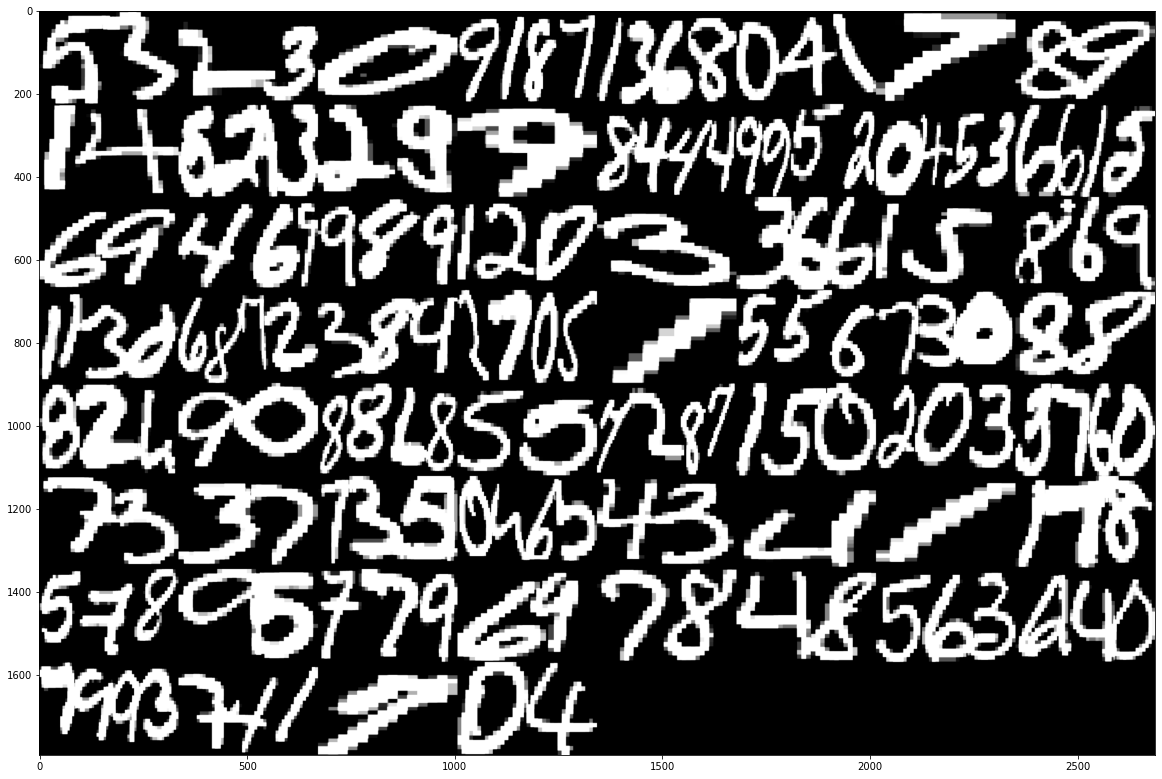

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3000, 1.0000, 0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')
tensor([0.0000, 0.0000, 0.3000, 1.0000, 0.3000, 0.0000, 0.3000, 1.0000, 0.3000,
        0.0000, 0.3000, 1.0000, 0.3000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000,
        0.0000, 0.0000], device='cuda:0')
tensor([0.0000, 0.3000, 1.0000, 0.3000, 0.0000, 0.3000, 1.0000, 0.3000, 0.0000,
        0.3000, 1.0000, 0.3000, 0.0000, 0.0000, 0.0000, 0.3000, 1.0000, 0.3000,
        0.0000, 0.0000], device=

In [0]:
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

dataiter       = iter(custom_train_loader)
images, labels = next(dataiter)

img   = utils.make_grid(images, padding=0).cpu()
npimg = img.numpy()
plt.figure(figsize=(20, 14))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

for label in labels:
    index = label
    print(index)

In [0]:
for epoch in range(1, EPOCHS + 1):
    train(model, custom_train_loader, optimizer, epoch)
    test_loss, test_accuracy  = evaluate(model, custom_test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy )) 

RuntimeError: ignored

In [0]:
torch.save(model.state_dict(), directory_path + 'VGG_center_model.pt')
new_model = VGG(make_layers(cfg['B']), num_classes=20, init_weights=True).to(DEVICE)
new_model.load_state_dict(torch.load(directory_path + 'VGG_center_model.pt'))
for epoch in range(1):
    test_loss, test_accuracy = evaluate(new_model, custom_test_loader)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[0] Test Loss: 0.0037, Accuracy: 87.55%
